In [1]:
import gpytorch

from bo_functions import best_error_advanced
from bo_functions import calc_ei_advanced
from bo_functions import LHS_Design
from bo_functions import create_y_data
from bo_functions import test_train_split
from bo_functions import ExactGPModel
from bo_functions import train_GP_model
from bo_functions import calc_GP_outputs
from bo_functions import calc_y_expected
from bo_functions import improvement_integral
from bo_functions import improvement_int_terms

from bo_plotters import plotter_adv
from bo_plotters import y_plotter_adv
from bo_plotters import stdev_plotter_adv
from bo_plotters import ei_plotter_adv
from bo_plotters import improvement_integral_plot
from bo_plotters import improvement_int_terms_plot

In [2]:
#Set noise parameters and load csv file to generate training data
noise_std = 0.1**2
all_p = LHS_Design("LHS_Toy_3_Input.csv")
all_y = create_y_data(all_p, noise_std)

#Separate training and testing data, uses default of an 80%/20% split
train_test_data = test_train_split(all_p,all_y)

train_p = train_test_data[0] #1x19
train_y = train_test_data[1] #1x19
test_p = train_test_data[2] #1x19
test_y = train_test_data[3] #1x19

In [3]:
# initialize likelihood and model
##Assumes a homoskedastic noise model p(y | f) = f + noise
likelihood = gpytorch.likelihoods.GaussianLikelihood()

# We will use the simplest form of GP model, exact inference
#Defines our model in terms of the class parameters in bo_functions
model = ExactGPModel(train_p, train_y, likelihood)

In [4]:
#Set number of training iterations and train GP
iterations = 500
train_GP_model(model,likelihood, train_p, train_y, iterations)

In [5]:
# Get into evaluation (predictive posterior) mode
#Puts model in evaluation mode
model.eval()
#Puts likelihood in evaluation mode
likelihood.eval();

In [6]:
#Calculates GP outputs for mean, variance, standard devaition, and y output
GP_Outputs = calc_GP_outputs(model,likelihood,test_p)

model_mean = GP_Outputs[0] #1x6
model_variance= GP_Outputs[1] #1x6
model_stdev = GP_Outputs[2] #1x6
model_y = GP_Outputs[3] #1x6

#Calculates expected y
y_exp = calc_y_expected(test_p, noise_std) #1x6

print("Model Mean \n", model_mean)
print("Model Variance \n", model_variance)
print("Model Standard Deviation \n", model_stdev)
print("Model y \n", model_y)
print("Y Value Expected \n", y_exp)

Model Mean 
 tensor([ 2.9885, -6.2378, -5.0304, -7.5639, -1.9611, -0.5206],
       dtype=torch.float64)
Model Variance 
 tensor([7.0452, 6.6659, 6.6159, 7.9151, 5.9328, 5.7719], dtype=torch.float64)
Model Standard Deviation 
 tensor([2.6543, 2.5818, 2.5721, 2.8134, 2.4357, 2.4025], dtype=torch.float64)
Model y 
 tensor([ 2.9885, -6.2378, -5.0304, -7.5639, -1.9611, -0.5206],
       dtype=torch.float64)
Y Value Expected 
 [  9.71894134  -6.44988063  -3.26090279 -11.84778408   0.01763784
   1.10481188]


In [7]:
#Calculates best_error and expected improvement
best_error = best_error_advanced(model_y, y_exp)[0] #Scaler
best_x = best_error_advanced(model_y, y_exp)[1] #1x3
# print("best x",best_x)
# print(test_p[1])
ei = calc_ei_advanced(best_error,model_mean,model_variance, y_exp) #1x6
print("Best Error is: ",best_error)
print("EI:",ei)

Upper bound is [ 2.6156029   0.          0.77040505 -1.44729247  0.89943113  0.76482107]
Lower bound is [ 2.455807   -0.16427983  0.60550603 -1.59805208  0.72529761  0.5882774 ]
pdf upper is [0.01304138 0.39894228 0.29650224 0.13997852 0.26622147 0.29777588]
cdf upper is [0.9955465  0.5        0.77947017 0.07390751 0.81578847 0.77781095]
pdf lower is [0.01955679 0.39359514 0.33212054 0.11126687 0.30667496 0.33555356]
cdf lower is [0.99297157 0.43475543 0.72757859 0.05501569 0.76586527 0.72182694]
[0.48390397 0.25       0.35352012 0.07653083 0.36880489 0.35284039]
[0.44979289 0.25       0.12509329 0.2791207  0.12935701 0.12509513]
Best Error is:  0.04497439937172971
EI: [-0.47922132  0.27104816 -0.44023986 -1.32832078 -0.60569896 -0.39339416]


Lower Improvement Integrand is 
 [ 0.00000000e+00 -8.19334473e-18  0.00000000e+00  0.00000000e+00
  2.97917904e-17  0.00000000e+00]
Upper Improvement Integrand is 
 [-4.88660916e-18  0.00000000e+00  0.00000000e+00  0.00000000e+00
  0.00000000e+00  0.00000000e+00]


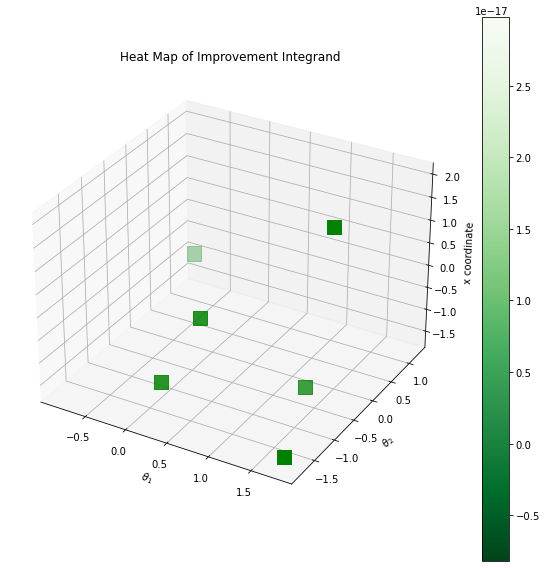

None


In [8]:
Integrand_values = improvement_integral(best_error,model_mean,model_variance,y_exp)
print("Lower Improvement Integrand is \n",Integrand_values[0] )
print("Upper Improvement Integrand is \n",Integrand_values[1] )
print(improvement_integral_plot(test_p,Integrand_values))

Index:  1


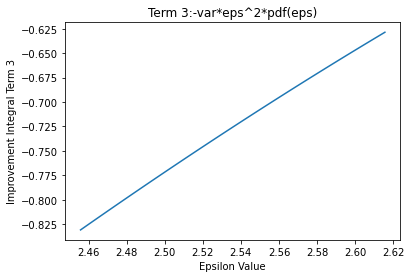

Index:  2


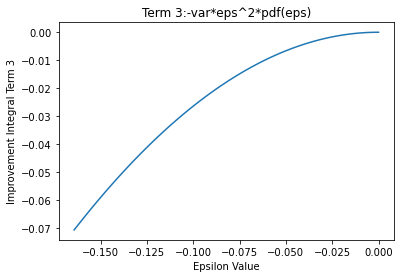

Index:  3


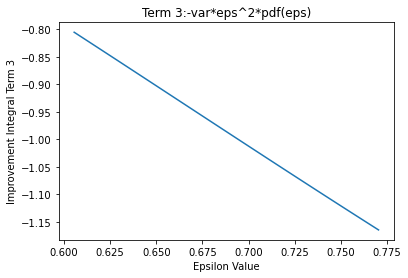

Index:  4


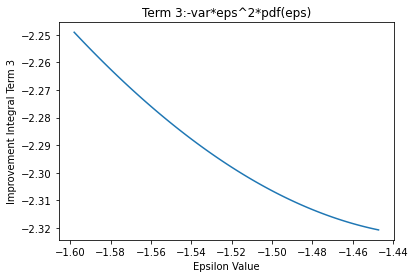

Index:  5


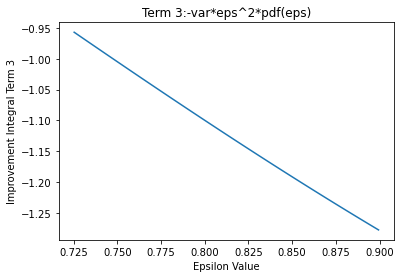

In [9]:
steps = 100
term_num = 3
index_num = 5

I_terms = improvement_int_terms(best_error,model_mean,model_variance,y_exp,steps)

improvement_int_terms_plot(I_terms,term_num, index_num)